In [129]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import astropy 
#from astropy import units as u
#from astropy import constants as const

%matplotlib inline 
#for jupyter notebook

In [253]:
class Distribution():
    #redshift info
    low = np.array([])
    mean = np.array([])
    high = np.array([])
    #bin value
    value = np.array([])

    z_min = 0
    z_max = 4

    def __init__(self,filename, path="load_nz/"):
        data =np.loadtxt(path+filename)
        self.low = data[:,0]
        self.mean = data[:,1]
        self.high = data[:,2]
        self.value = data[:,3]

    #interpolate result
    def interpolate(self, z):
        return np.interp(z, self.mean, self.value)
    def __call__(self, z):
        if(z< self.z_min or z > self.z_max): #seems to be never called since z in bin integral by definition >= zmin
            return 0
        return self.interpolate(z)

    #def resample():

    def devide_into_equal_bins(self, n=10, z_min=0, z_max=4):
        #cumulative distribution (possibly not the most accurate...)
        self.z_min = z_min 
        self.z_max = z_max
        mask = np.logical_and(self.mean>=z_min,  self.mean<=z_max)
        cumsum = np.cumsum(self.value[mask])
        step = cumsum[-1]/n
        bin_cuts = np.arange(0, cumsum[-1]+step, step)
        return np.interp(bin_cuts, cumsum, self.high[mask])#high is working better than mean (makes sense)
        # low_cuts = np.interp(bin_cuts, cumsum, self.low)
        # high_cuts = np.interp(bin_cuts, cumsum, self.high)
        # return low_cuts, high_cuts


#the naming here is maximally confusing but I think it is right this way around:
lenses = Distribution("zdistri_WFIRST_clustering_fine_bin.txt")
sources = Distribution("zdistri_WFIRST_lensing_fine_bin.txt")

Text(0.5, 0, 'redshift')

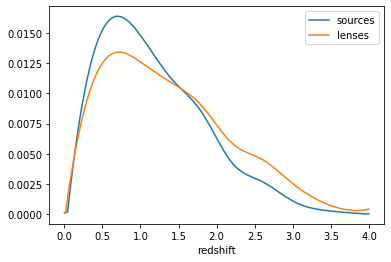

In [254]:
plt.plot(sources.mean, sources.value, label="sources")
plt.plot(lenses.mean, lenses.value, label="lenses")
plt.legend()
plt.xlabel("redshift")

In [255]:
from scipy import integrate
integrate.quad(lenses, 0, 4)

(0.026374012032903554, 1.360002221676565e-06)

In [243]:
lenses.devide_into_equal_bins()

array([0.01333   , 0.40890153, 0.61972515, 0.81697439, 1.020846  ,
       1.23989658, 1.47788827, 1.74037932, 2.06299616, 2.53974226,
       4.        ])

$$n^i_x(z_{\mathrm{ph}}) = \int_{z^i_{\mathrm{min},x}}^{z^i_{\mathrm{max},x}} dz \, n_{\mathrm{x}}(z) \, p^i\left(z_{\mathrm{ph}}|z,x\right)\,, $$

$$p^i\left(z_{\mathrm{ph}}|z,x\right) = \frac{1}{\sqrt{2\pi}\sigma_{z,x}(1+z)} \exp\left[-\frac{\left(z-z_{\mathrm{ph}} - \Delta^i_{z,x}\right)^2}{2\left(\sigma_{z,x}(1+z)\right)^2}\right]\,.$$



In [262]:
def calc_bins(equal_bins, distribution, sampling=np.linspace(0,4, 400), sigma = 0.01, Delta_i = 0.0): #need to make Delta_i an array!
    n_bins = len(equal_bins)-1
    bins = np.zeros((n_bins, len(sampling)))
    for i in range(n_bins):
        z_min = equal_bins[i]
        z_max = equal_bins[i+1]
        for zph_index in range(len(sampling)):
            p = P(sampling[zph_index], sigma, Delta_i)
            bins[i,zph_index ]  = integrate.quad(lambda z: distribution(z)*p(z), z_min, z_max)[0] 
    return bins, sampling
class P():
    zph = 0.
    sigma = 0.
    Delta_i = 0.
    def __init__(self,zph, sigma, Delta_i):
        self.zph = zph 
        self.sigma = sigma 
        self.Delta_i = Delta_i

    def __call__(self,z):
        prefactor = 1/(np.sqrt(2*np.pi)*self.sigma*(1+z))
        expfactor = -1/(2*(self.sigma* (1+z))**2)
        return prefactor * np.exp(expfactor * (z - self.zph - self.Delta_i)*(z - self.zph - self.Delta_i))


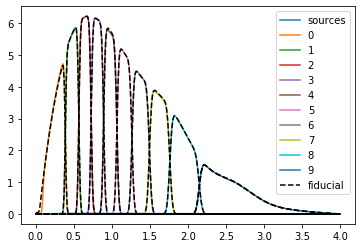

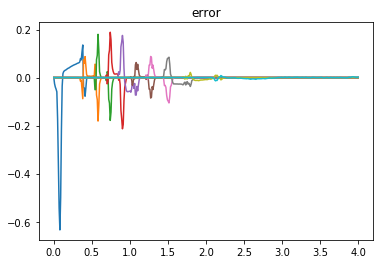

In [268]:
#full distribution
plt.plot(sources.mean, sources.value, label="sources")


sources_bins, z = calc_bins(sources.devide_into_equal_bins(z_min=0.08), sources, sigma = 0.01, Delta_i = 0.0)
sources_bins = sources_bins *380
for i in range(sources_bins.shape[0]):
    plt.plot(z, sources_bins[i,:], label=str(i))
# plt.yscale("log")
# plt.ylim(1, 10)



pathSOURCES = "load_nz/WFIRST_zdist/original/WFIRST_zdist_sources_bin"
N_bins_SOURCES = 10

sources_old = {}
for i in range(N_bins_SOURCES):
    temp = np.loadtxt(pathSOURCES+str(i)+".txt")
    sources_old[i] = temp
for i in range(N_bins_SOURCES):
    plt.plot(sources_old[i][:,0], sources_old[i][:,1],"--", color="black")
plt.plot(sources_old[i][:,0], sources_old[i][:,1],"--", color="black", label="fiducial")
#for comparison the dataset from Cyrille
plt.legend()


plt.figure()
plt.title("error")
for i in range(sources_bins.shape[0]):
    plt.plot(z, sources_bins[i,:]- np.interp(z, sources_old[i][:,0], sources_old[i][:,1]), label=str(i))


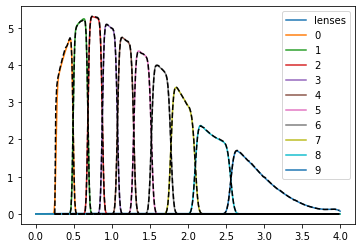

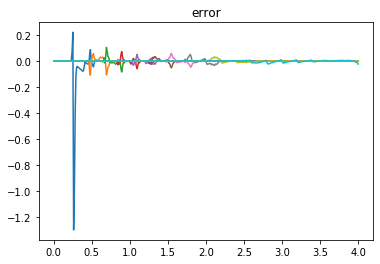

In [261]:
plt.plot(lenses.mean, lenses.value, label="lenses")

lenses_bins, z = calc_bins(lenses.devide_into_equal_bins(n=10, z_min=0.26), lenses, sigma = 0.01, Delta_i = 0.0)
lenses_bins = lenses_bins*395
for i in range(lenses_bins.shape[0]):
    plt.plot(z, lenses_bins[i,:], label=str(i))
# plt.yscale("log")
# plt.ylim(0.002, 0.02)
plt.legend()


pathLENSES = "load_nz/WFIRST_zdist/original/WFIRST_zdist_lenses_bin"
N_bins_LENSES = 10

lenses_old = {}
for i in range(N_bins_LENSES):
    temp = np.loadtxt(pathLENSES+str(i)+".txt")
    lenses_old[i] = temp
for i in range(N_bins_LENSES):
    plt.plot(lenses_old[i][:,0], lenses_old[i][:,1],"--", color="black")

plt.figure()
plt.title("error")
for i in range(10):
    plt.plot(z, lenses_bins[i,:]- np.interp(z, lenses_old[i][:,0], lenses_old[i][:,1]), label=str(i))


** There must be some kind of lower redshift cutoff for the lensins one **

In [248]:
lenses(0.1)

HI


0